In [1]:
import pandas as pd
import json
import os
import numpy as np
import matplotlib.pyplot as pplot
import sys
sys.path.insert(0, '../..')
from astrotate import array, ep, utils
import importlib
import shutil

In [ ]:
importlib.reload(ep)
importlib.reload(utils)

In [ ]:
# !git


# Define the experiment folder

In [4]:
exp_date = '190926' # <==== set experiment date as folder name.

exp_folder = 'C:\\Shared_Experimental_Data' # Don't need to change if you use it in this computer.

# ===================don't change below part =======================================================
today_folder = os.path.join(exp_folder, exp_date)  
template_file = 'data_log_template.xlsx'
target_template_file = os.path.join(today_folder, template_file)
if not os.path.exists(target_template_file):
    shutil.copyfile(template_file, target_template_file)

## please fill the form then run the next step

In [5]:
treatment_df = pd.read_excel(target_template_file, sheet_name = 'treatment').astype({'trial': 'str'})
trial_df = pd.read_excel(target_template_file, sheet_name = 'trials').astype({'trial': 'str'})
channel_df = pd.read_excel(target_template_file, sheet_name = 'channel').dropna(subset=['channel_name'], inplace=False)

In [6]:
def bint1D(array, binsize, setint = False):
    # smooth 1D array
    remains = len(array) % binsize
    array1 = np.reshape(array[0:len(array)-remains], [-1, binsize])
    array2 = np.mean(array1, axis = 1)
    if remains > binsize/2:
        array2 = np.append(array2, np.mean(array[-remains:]))
    if setint:
        array2 = np.around(array2).astype(int)
    return(array2)

def get_array(expfolder = today_folder, treatment_df = treatment_df, trial_df = trial_df, channel_df = channel_df):
    
    #treatment_df = treatment_df.astype({'trial': 'str'}) # after load from csv, the trial is int64
    trials = os.listdir(expfolder)
    required_trials = [str(x)+'.txt' for x in trial_df.loc[:, 'trial'].values]
    files = [os.path.join(expfolder,x) for x in trials if x.split('-')[-1] in required_trials]
    
    files.sort()
    data = {}
    for i in range(len(channel_df)):
        thetype = channel_df.loc[i, 'data_type']
        data[thetype] = {'present_length':0, 'data':[], 'treat_point': {}, 'bin_size':str(channel_df.loc[i, 'output_bin_secsize'])+'sec'}
        channel = channel_df.loc[i, 'channel_name']
        scanRate = channel_df.loc[i, 'output_bin_secsize']
        print('start to extract %s data' % thetype)

        for j in range(len(files)):
            file = files[j]
            outputRate = trial_df.loc[i, 'output_freq']
            df = pd.read_csv(file, sep = '\t')
            values = df.loc[:, channel].values
            values = values[~np.isnan(values)]
            values = bint1D(values, int(scanRate*outputRate), setint = (channel in ['multiunit']))
            data[thetype]['data'] = np.append(data[thetype]['data'], values)

            tmp_trial = file.split('-')[-1][0:-4]
            #timepoint_df.loc[len(timepoint_df), :] = [tmp_trial, len(values)]
            print('%s done, length is %d' % (file, len(values)))
            if tmp_trial in treatment_df.loc[:, 'trial'].tolist():
                
                tmp_row = treatment_df.index[treatment_df.loc[:, 'trial'] == tmp_trial].tolist()[0]
                tmp_id = str(treatment_df.loc[tmp_row, 'treatment_id'])
                tmp_sec = treatment_df.loc[tmp_row, 'sec']#.value#astype(float)
                print(tmp_trial, tmp_id, tmp_sec)
                data[thetype]['treat_point'][tmp_id] = data[thetype]['present_length'] + int(tmp_sec/scanRate)
                print(data[thetype]['present_length'], int(tmp_sec/outputRate))
                print(data[thetype]['treat_point'][tmp_id])

            data[thetype]['present_length'] = data[thetype]['present_length'] + len(values)
    return(data)
    
def create_data_info(data):
    datainfo = {}
    for key, value in data.items():
        datainfo[key] = {}
        datainfo[key]['treat_point'] = value['treat_point']
        datainfo[key]['bin_size'] = value['bin_size']
        datainfo[key]['file_path'] = key+'.csv'
        
        if key == 'bf':
            fmt = '%.3e'
            
        elif key == 'multiunit':
            fmt = '%d'
            
        elif key == 'ECoG':
            fmt = '%.4e'
            
        np.savetxt(os.path.join(today_folder, datainfo[key]['file_path']), value['data'], fmt = fmt)
        print('%s data saved at %s' % (key, os.path.join(today_folder, datainfo[key]['file_path'])))
    
    utils.writejson(os.path.join(today_folder, 'datainfo.json'), datainfo)
    return(datainfo)

def tidy_ecog_data(datainfo, csdkey): # As ECoG data pretty big, I don't want to save whole period. Now I will just save from 10 min before CSD and 1 h after CSD.
    data = np.loadtxt(os.path.join(today_folder, datainfo['ECoG']['file_path']))
    points_before_csd = 10 * 60 / float(datainfo['ECoG']['bin_size'][:-3])
    points_after_csd = 60 * 60 / float(datainfo['ECoG']['bin_size'][:-3])
    t0 = int(datainfo['ECoG']['treat_point'][csdkey] - points_before_csd)
    t1 = int(datainfo['ECoG']['treat_point'][csdkey] + points_after_csd)
    newdata = data[t0:t1]
    np.savetxt(os.path.join(today_folder, datainfo['ECoG']['file_path']), newdata)
    newdic = {}
    for key, value in datainfo['ECoG']['treat_point'].items():
        if value - t0 > 0:
            newdic[key] = value - t0
    datainfo['ECoG']['treat_point'] = newdic
    utils.writejson(os.path.join(today_folder, 'datainfo.json'), datainfo)
    
    


        
    

In [7]:
data = get_array()

start to extract bf data
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-12-38-2454.txt done, length is 360
2454 0 0
0 0
0
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-13-08-2455.txt done, length is 360
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-13-41-2456.txt done, length is 360
2456 1 0
720 0
720
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-14-11-2457.txt done, length is 360
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-14-41-2458.txt done, length is 360
2458 2 300
1440 0
1500
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-15-11-2459.txt done, length is 360
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-15-42-2460.txt done, length is 360
start to extract multiunit data
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-12-38-2454.txt done, length is 1800
2454 0 0
0 0
0
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-13-08-2455.txt done, length is 1800
C:\Shared_Experimental_Data\190926\spon-Sep-26-19-13-41-2456.txt done, length is 1800
2456 1 0
3600 0
36

In [8]:
datainfo = create_data_info(data) # This function will create both datainfo.json and also save data to each csv files.
print(datainfo)

bf data saved at C:\Shared_Experimental_Data\190926\bf.csv
multiunit data saved at C:\Shared_Experimental_Data\190926\multiunit.csv
ECoG data saved at C:\Shared_Experimental_Data\190926\ECoG.csv
{'bf': {'treat_point': {'0': 0, '1': 720, '2': 1500}, 'bin_size': '5.0sec', 'file_path': 'bf.csv'}, 'multiunit': {'treat_point': {'0': 0, '1': 3600, '2': 7500}, 'bin_size': '1.0sec', 'file_path': 'multiunit.csv'}, 'ECoG': {'treat_point': {'0': 0, '1': 3600430, '2': 7500685}, 'bin_size': '0.001sec', 'file_path': 'ECoG.csv'}}


In [9]:
# This is a dangerous function. Please make sure your parameters before you run this function. 
# It will crop your data and overwrite the old file.

tidy_ecog_data(datainfo, '2') 

# Check the output

12600


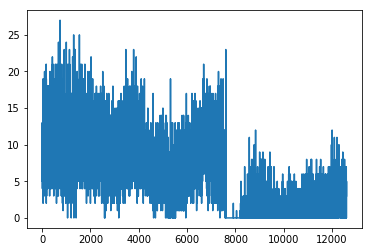

In [12]:
# The channel you want to check:
channel = 'multiunit' # bf multiunit ECoG
d = np.loadtxt(os.path.join(os.path.join(today_folder, channel+'.csv')))
print(len(d))
pplot.plot(d)

In [ ]:
# np.savetxt(os.path.join(exp_folder, output_file_name), data, fmt='%.4e', delimiter=",")